<a href="https://colab.research.google.com/github/quaneh/tutorials-portfolio/blob/main/Knowledge_Graphs_America's_Cup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Graphs - America's Cup

A colleague recently made a knowledge sharing presentation about Knowledge Graphs (KGs), and it inspired me to dig a bit deeper and try creating a simple example myself.

The America's Cup is about to kick off so I thought why not create a KG tutorial where we model a knowledge graph using data about the competition.

We'll scrape data about the competition from the web. Then, we'll use Python libraries to create and visualize the graph, focusing on relationships between teams, boats, sponsors, and more. This example will help us understand how to model complex real-world information into a structured graph.

# Data Collection - Web Scraping

In the code below we'll use **BeautifulSoup** and **requests** to fetch and parse the America's Cup 2024 Wikipedia page.

Web scraping is a pretty well-known technique, so I won't go into too much detail here.

One thing I will mention, however, is that I originally tried to scrape the entire wikipedia page. The result was a mess. Different tables had different formats and different representations of information. Little details here and there made the data useless for creating my KG.

In the end I realised that all of the information I needed was in the second table on the wikipedia page.

In the future I'll probably do some investigation on how we can use LLMs to scrape web pages more easily, so stay tuned.



In [5]:
!pip install requests beautifulsoup4

In [6]:
from bs4 import BeautifulSoup
import re
import requests

# Load the HTML content
def load_html(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        raise Exception(f"Failed to load page with status code {response.status_code}")

# Function to discard anything after a new line in a cell
# We don't want any extra info that's going to create mess and ruin our extraction process
def clean_cell_text(text):
  text = re.sub(r'\[\d+\]', '', text)
  return text.split('\n')[0].strip()

# Function to remove anything within <p> tags in a table cell
# If you check out the table on the wikipedia page you'll see that there is some extra data about who the "defender" of the cup is.
# We don't want this info messing up our KG
def remove_paragraph_tags(cell):
    # Remove the <p> tags but keep other text inside the cell
    for p_tag in cell.find_all('p'):
        p_tag.decompose()  # Removes the <p> tag and its content
    return cell.get_text(strip=True)

# Find the second table of class 'wikitable' and extract its content
def extract_table_content(html_content):
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find all tables with class 'wikitable'
    tables = soup.find_all('table', class_='wikitable')

    # Ensure there are at least two tables
    if len(tables) < 2:
        raise Exception("There are fewer than two 'wikitable' tables on the page.")

    # Select the second 'wikitable'
    second_table = tables[1]

    # Initialize a string to store the table data
    table_content = ""

    # Find the table headers
    headers = [header.get_text(strip=True) for header in second_table.find_all('th')]

    # Find the table rows
    rows = second_table.find_all('tr')

    # Loop through the rows and extract cell data
    for row in rows:
        cells = row.find_all(['td'])
        row_content = []
        for i, cell in enumerate(cells):
            if i < len(headers):  # Ensure we don't go out of bounds with headers
                # Remove <p> tags and clean the cell content, discard anything after a new line
                cell_text = clean_cell_text(remove_paragraph_tags(cell))
                row_content.append(f"{headers[i]}: {cell_text}")
        # Join the row contents with a comma and add a new line after each row
        if row_content:
            table_content += ", ".join(row_content) + "\n"

    return table_content

# Example usage:
url = "https://en.wikipedia.org/wiki/2024_America%27s_Cup"
html_content = load_html(url)

# Extract the content of the second 'wikitable'
table_content = extract_table_content(html_content)

# Print the extracted table content
print(table_content)


Team: Emirates Team New Zealand, Yacht Club: Royal New Zealand Yacht Squadron, Skipper: Peter Burling, AC75 Name: Taihoro, Shipyard: Team New Zealand, Unveiled: 11 April 2024, Launched: 12 April 2024, Notes: 
Team: Alinghi Red Bull Racing, Yacht Club: Société Nautique de Genève, Skipper: Arnaud Psarofaghis, AC75 Name: BoatOne, Shipyard: Alinghi Red Bull Racing, Unveiled: 5 April 2024, Launched: 16 April 2024, Notes: 
Team: Luna Rossa Prada Pirelli, Yacht Club: Circolo della Vela Sicilia, Skipper: Max Sirena, AC75 Name: Luna Rossa, Shipyard: Persico Marine, Unveiled: 13 April 2024, Launched: 13 April 2024, Notes: 
Team: NYYC American Magic, Yacht Club: New York Yacht Club, Skipper: Terry Hutchinson, AC75 Name: Patriot, Shipyard: American Magic, Unveiled: 25 April 2024, Launched: 7 May 2024, Notes: 
Team: INEOS Britannia, Yacht Club: Royal Yacht Squadron, Skipper: Ben Ainslie, AC75 Name: Britannia, Shipyard: Carrington Boats, Unveiled: 20 April 2024, Launched: 26 April 2024, Notes: 
Team

Amazing!! We now have all of the information we need to create our Knowledge Graph.

# Entity and Relationship Extraction

Now that the text is cleaned, we can pass it to an LLM to extract entities (such as teams, sponsors, events, boats, etc.) and their relationships.

We specify the output data structure we want in the system prompt.

We can then use a JSON parser to ensure this is in a data format that can be ingested to create our KG.

In [7]:
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00


In [8]:
from google.colab import userdata
# REMEMBER!! Don't put your API key in any public repo. Store and access it as a secret or environment variable instead.
open_ai_key = userdata.get('openAIKey')

In [10]:
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt

# Function to extract entities and relationships in a structured format
def extract_entities_and_relationships(text):
    # System prompt for guiding the LLM
    system_prompt = """
    You are a knowledge extraction assistant. Your task is to extract key entities (such as teams, sponsors, boats, and events) and their relationships from text.
    Return the data in a list of triples in this format:
    [
      {"entity1": "Entity1", "relationship": "Relation", "entity2": "Entity2"}
    ]
    Each item in the list should follow this JSON format.
    """

    # User prompt containing the text we want to process
    user_prompt = f"Extract key entities and relationships from the following text:\n\n{text}"

    client = OpenAI(api_key=open_ai_key)

    # Send the request to OpenAI API
    response = client.chat.completions.create(
        model="gpt-4",  # Use 'gpt-3.5-turbo' if GPT-4 is unavailable
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=0
    )

    # Return the structured JSON response
    return response.choices[0].message.content


# Extract entities and relationships in a structured format
extracted_data = extract_entities_and_relationships(table_content)
print("Extracted Data:\n", extracted_data)


Extracted Data:
 [
  {"entity1": "Emirates Team New Zealand", "relationship": "belongs to", "entity2": "Royal New Zealand Yacht Squadron"},
  {"entity1": "Peter Burling", "relationship": "is the skipper of", "entity2": "Emirates Team New Zealand"},
  {"entity1": "Taihoro", "relationship": "is the AC75 of", "entity2": "Emirates Team New Zealand"},
  {"entity1": "Team New Zealand", "relationship": "is the shipyard of", "entity2": "Taihoro"},
  {"entity1": "Alinghi Red Bull Racing", "relationship": "belongs to", "entity2": "Société Nautique de Genève"},
  {"entity1": "Arnaud Psarofaghis", "relationship": "is the skipper of", "entity2": "Alinghi Red Bull Racing"},
  {"entity1": "BoatOne", "relationship": "is the AC75 of", "entity2": "Alinghi Red Bull Racing"},
  {"entity1": "Alinghi Red Bull Racing", "relationship": "is the shipyard of", "entity2": "BoatOne"},
  {"entity1": "Luna Rossa Prada Pirelli", "relationship": "belongs to", "entity2": "Circolo della Vela Sicilia"},
  {"entity1": "Ma

# Creating the Knowledge Graph

We asked the LLM to output data in the format:


```
[
  {"entity1": "Entity1", "relationship": "Relation", "entity2": "Entity2"}
]
```
This allows us to create a 'triple' that describes the relationship between two entities.

(Entity_1 --> relationship --> Entity_2)

Our entities will be represended as Nodes, and the relationships will be represented as Edges.

The JSON parser turns our extracted data into triples, and the networkx library can be used to create nodes and edges based on these triples.


In [11]:
# Parsing the output as JSON-like format (you can use ast.literal_eval if it returns a JSON string)
import json
triples = json.loads(extracted_data)

# Creating the knowledge graph using NetworkX
G = nx.Graph()

# Add triples to the graph
for triple in triples:
    entity1 = triple["entity1"]
    relationship = triple["relationship"]
    entity2 = triple["entity2"]

    # Add nodes and edges
    G.add_node(entity1)
    G.add_node(entity2)
    G.add_edge(entity1, entity2, relation=relationship)


# Visualising the Graph

Next we visualise the Graph. We'll use the spring_layout function from the NetowrkX library, along with good old Matplotlib.

To be honest, the graph could be better, but it still gives us a good idea of how information is represented in our Knowledge Graph.

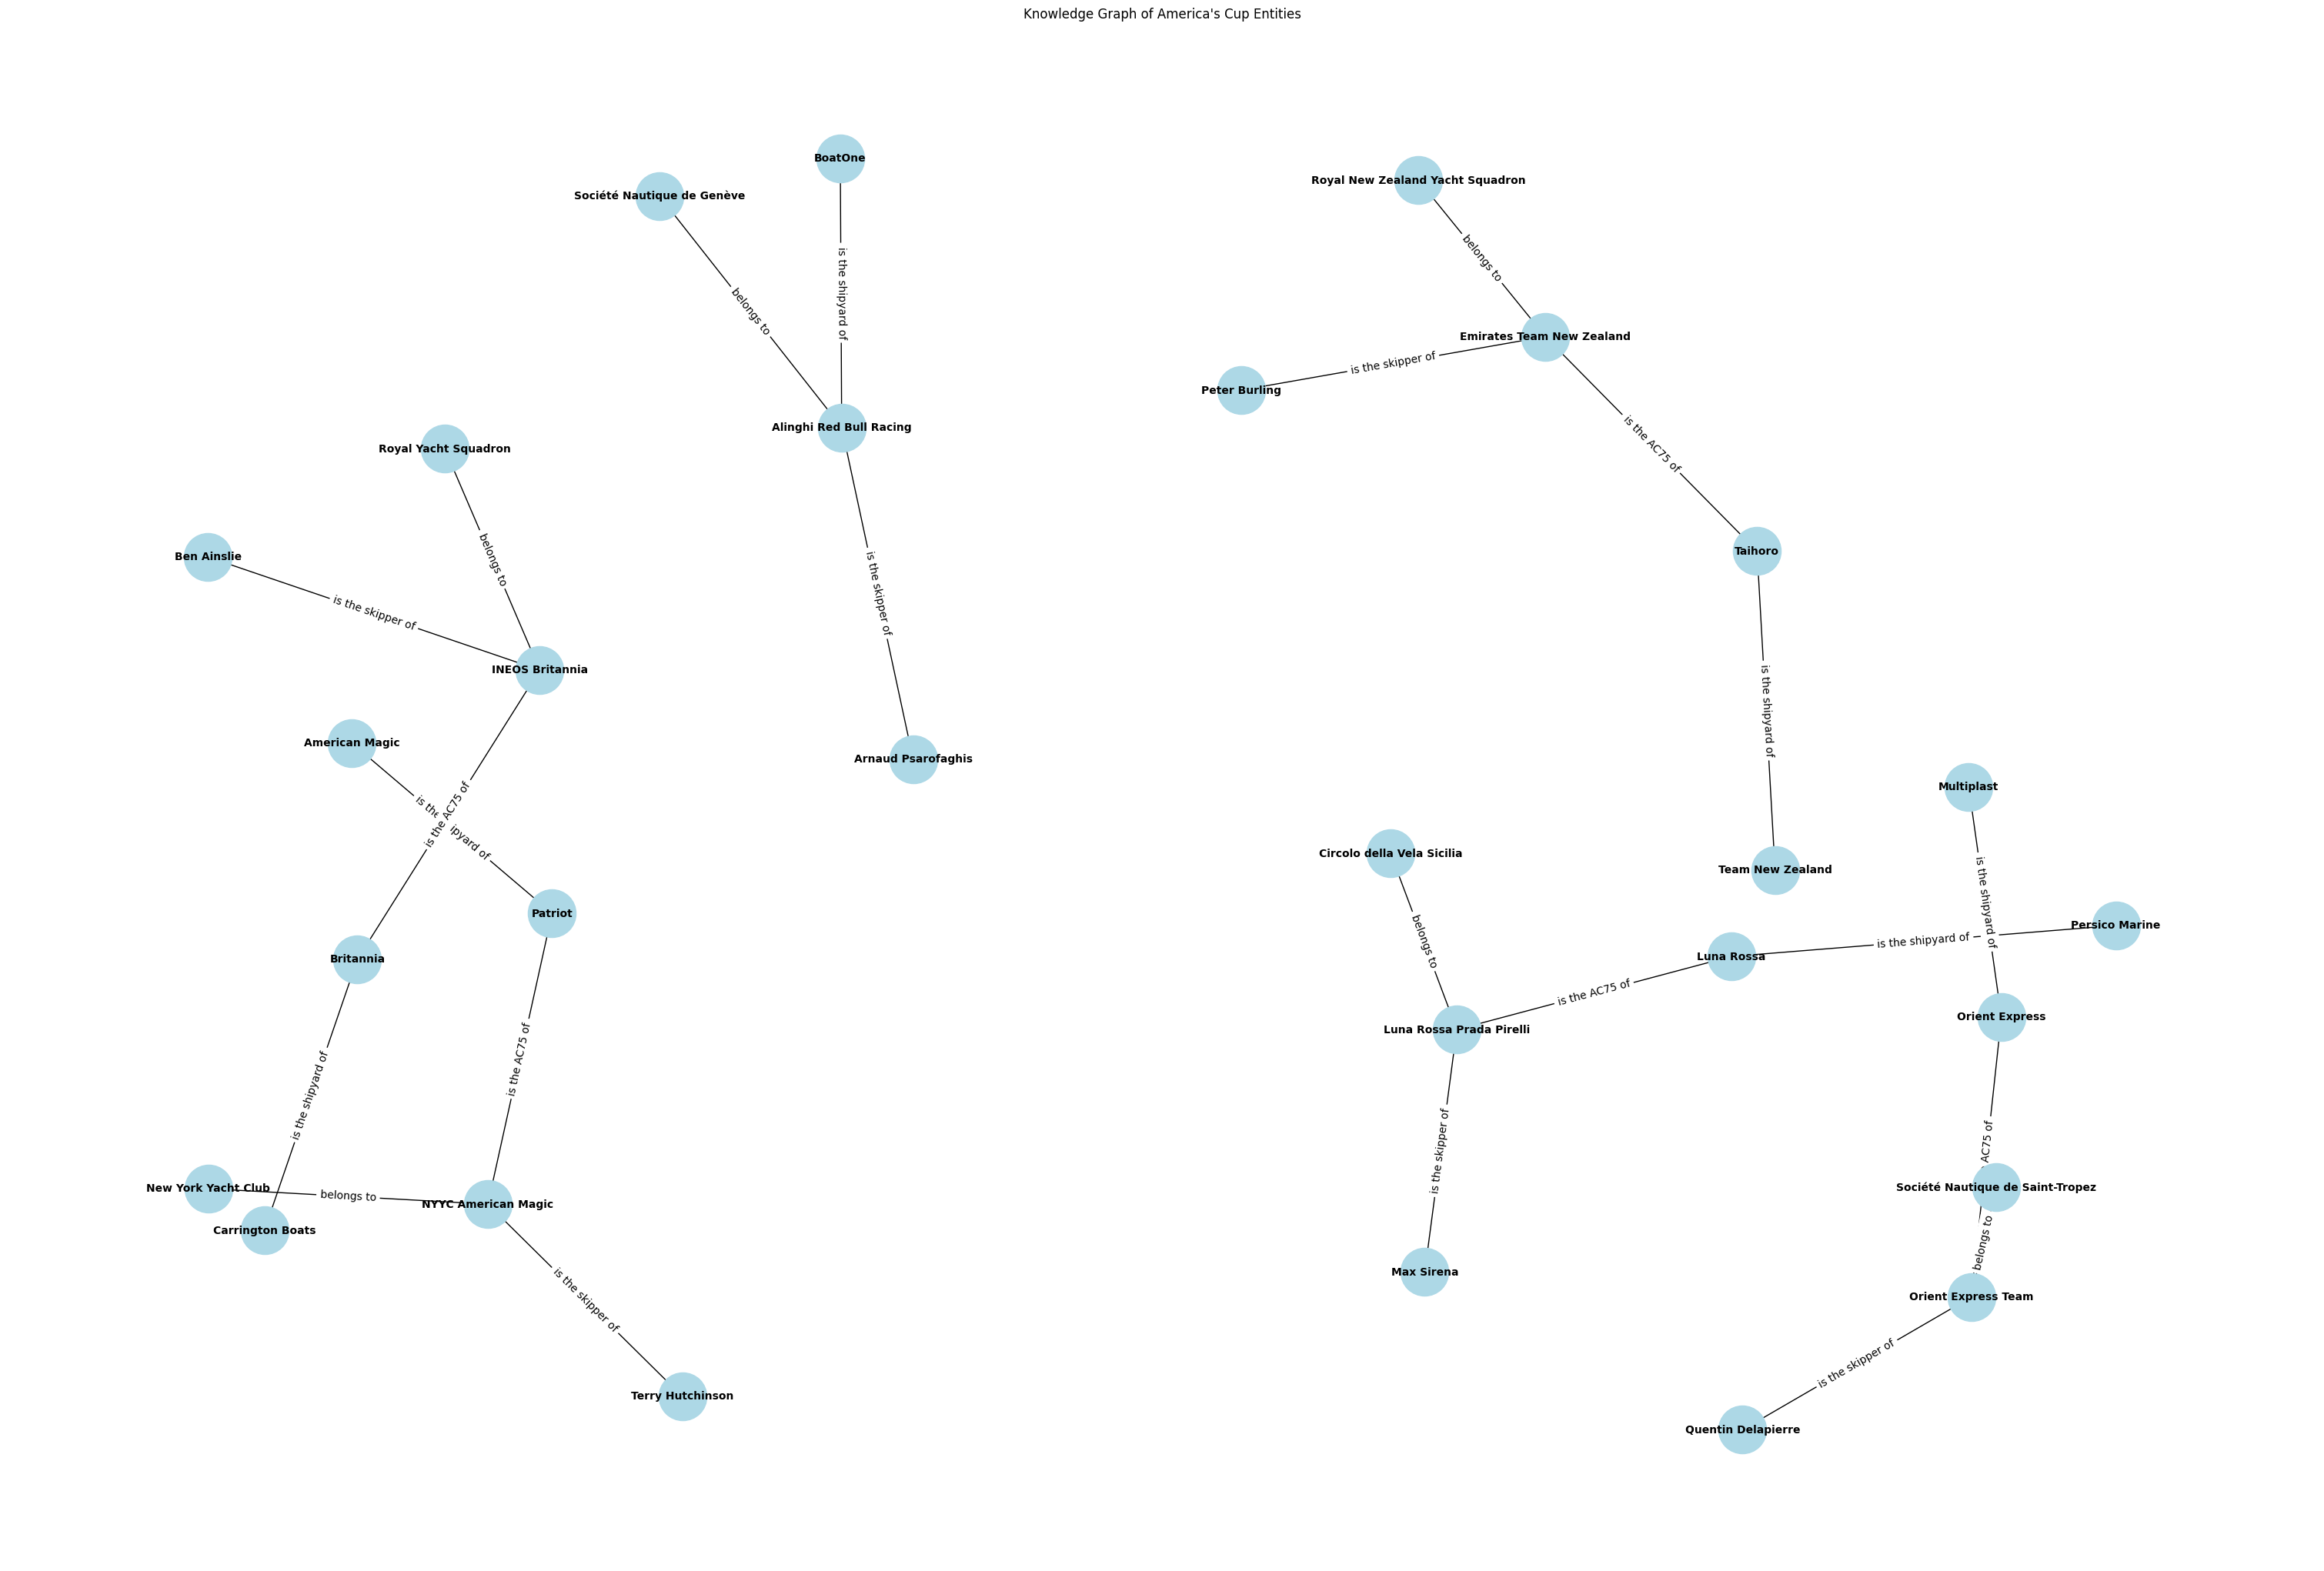

In [12]:
# Visualize the graph
# We initialise our graph layout here. K determines the space between nodes. Higher == more space
pos = nx.spring_layout(G, k=0.5, iterations=50)
plt.figure(figsize=(30, 20))
# First we draw the netwok itself
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold')
# Then we define our edge labels and add them to the plot
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title("Knowledge Graph of America's Cup Entities")
plt.show()

# Extracting information

Now we want to extract some information from our graph programatically.

Let's write a function to find the boat that a given team sails.
Note: The AC75 is the generic yacht type that all teams in the America's Cup. We will find the name of the AC75 for a given team.

In [25]:
def get_team_boat(G, team_name):
    for neighbors in G.neighbors(team_name):
        edge_data = G.get_edge_data(team_name, neighbors)
        if edge_data['relation'] == 'is the AC75 of':
            return neighbors
    return None

In [26]:
teams = [node for node in G.nodes() if 'Team' in node or 'Racing' in node]
print("Available teams:", teams)

team_name = input("Enter a team name to find its boat: ")
boat = get_team_boat(G, team_name)
if boat:
    print(f"{team_name} sails the boat: {boat}")
else:
    print(f"No boat found for {team_name}")

Available teams: ['Emirates Team New Zealand', 'Team New Zealand', 'Alinghi Red Bull Racing', 'Orient Express Team']
Enter a team name to find its boat: Emirates Team New Zealand
Emirates Team New Zealand sails the boat: Taihoro


For this example we used an undirected graph. In a more complex usecase a Directed Grapg may be more appropriate: https://networkx.org/documentation/stable/reference/classes/digraph.html

Please also note that for real-world applications, a simple graphing tool like NetworkX may not be appropriate. Neo4j is a very popular graph database that may be more suitable for complex applications: https://neo4j.com/

I hope you found this tutorial useful.